# Demo: Quantum Machine Learning

In [7]:
!pip install pennylane --upgrade
!pip install torch
!pip install torchsummary
!pip install -U scikit-learn


In [8]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

import pennylane as qml
from pennylane import numpy as np

## Data Encoding

### Basis Encoding

In [9]:
# Use Template
from pennylane.templates.embeddings import BasisEmbedding

In [10]:
# Define Quantum Device, here: Default-Simulator with 6 Qubits
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(data):
    BasisEmbedding(features=data, wires=range(2))
    return qml.state()

data=[0,0]
print(data,'-->',circuit(data))

data=[0,1]
print(data,'-->',circuit(data))

data=[1,0]
print(data,'-->',circuit(data))

data=[1,1]
print(data,'-->',circuit(data))



[0, 0] --> [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0, 1] --> [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[1, 0] --> [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
[1, 1] --> [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


### Amplitude Encoding

In [11]:
# Use Template
from pennylane.templates.embeddings import AmplitudeEmbedding


In [12]:
dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev)
def circuit(data):
    AmplitudeEmbedding(features=data, wires=range(2),normalize=True)
    return qml.state()

data = [6,-10.3,13.52,4.2]
norm=np.linalg.norm(data)

print(data,',',data/norm,'-->',circuit(data))


[6, -10.3, 13.52, 4.2] , [ 0.32419628 -0.55653695  0.73052229  0.2269374 ] --> [ 0.32419628+0.j -0.55653695+0.j  0.73052229+0.j  0.2269374 +0.j]


### Angle Encoding

In [13]:
# Use Template
from pennylane.templates.embeddings import AngleEmbedding

In [14]:
dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev)
def circuit(data):
    AngleEmbedding(features=data, wires=range(4),rotation='Y')
    return qml.expval(qml.PauliZ(0))

data = [6,-10.3,13.52,4.2]

#print(qml.draw(circuit, expansion_strategy="device")(data))
print(qml.draw(circuit,level=None)(data))

0: ──RY(6.00)───┤  <Z>
1: ──RY(-10.30)─┤     
2: ──RY(13.52)──┤     
3: ──RY(4.20)───┤     


### SU(2) Encoding

In [15]:
dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def circuit(data):
    qml.Rot(data[0],data[1],data[2], wires=0)
    return qml.expval(qml.PauliZ(0))

data = [6,-10.3,13.52]

#print(qml.draw(circuit, expansion_strategy="device")(data))
print(qml.draw(circuit,level=None)(data))

0: ──Rot(6.00,-10.30,13.52)─┤  <Z>


If you have more qubits available, use them to encode the data and then entangle the qubits:

In [16]:
dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev)
def circuit(data):
    qml.Rot(data[0],data[1],data[2], wires=0)
    qml.Rot(data[0],data[1],data[2], wires=1)
    qml.CNOT(wires=[0, 1])
    return  qml.expval(qml.PauliZ(0))

data = [6,-10.3,13.52]

#print(qml.draw(circuit, expansion_strategy="device")(data))
print(qml.draw(circuit,level=None)(data))

0: ──Rot(6.00,-10.30,13.52)─╭●─┤  <Z>
1: ──Rot(6.00,-10.30,13.52)─╰X─┤     


## Variational Circuits

In PennyLane there are pre-defined circuits:

### BasicEntangling Layers

Each layer consists on a single qubit rotation followed by a chain of CNOT-gates (1. with 2. Qubit, 2.Qubit with 3. Qubit, ... Last Qubit with 1. Qubit)

In [17]:
# Import the emplate
from pennylane.templates.embeddings import AngleEmbedding

In [18]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(weights):
    qml.BasicEntanglerLayers(weights=weights, wires=range(2))
    return  qml.expval(qml.PauliZ(0))

circuit([[np.pi, np.pi/2]])
#print(qml.draw(circuit, expansion_strategy="device")(([[np.pi, np.pi/2]])))
print(qml.draw(circuit,level=None)((([[np.pi, np.pi/2]]))))

0: ──RX(3.14)─╭●─┤  <Z>
1: ──RX(1.57)─╰X─┤     


### Strongly Entangling Layers

General SU(2) rotation with three parameters per qubit followd by a chain of CNOT- (or CZ-) gates

In [19]:
# Import the template
from pennylane.templates import StronglyEntanglingLayers

In [20]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.PauliZ(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=4)
weights = np.random.random(size=shape)

#print(qml.draw(circuit, expansion_strategy="device")(weights))
print(qml.draw(circuit,level=None)(weights))

0: ──Rot(0.08,0.17,0.71)─╭●───────╭X─┤  <Z>
1: ──Rot(0.91,0.53,0.76)─╰X─╭●────│──┤     
2: ──Rot(0.40,0.86,0.99)────╰X─╭●─│──┤     
3: ──Rot(0.43,0.63,0.71)───────╰X─╰●─┤     


With the parameter "n_layers" more layers can be combined to enlarge the number of parameters:

In [21]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.PauliZ(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=3, n_wires=4)
weights = np.random.random(size=shape)

#print(qml.draw(circuit, expansion_strategy="device")(weights))
print(qml.draw(circuit,level=None)(weights))

0: ──Rot(0.78,0.97,0.04)─╭●───────╭X──Rot(0.20,0.90,0.24)─╭●────╭X──Rot(0.92,0.39,0.99)
1: ──Rot(0.39,0.65,0.25)─╰X─╭●────│───Rot(0.67,0.82,0.29)─│──╭●─│──╭X──────────────────
2: ──Rot(0.06,0.73,0.10)────╰X─╭●─│───Rot(0.51,0.68,0.68)─╰X─│──╰●─│───────────────────
3: ──Rot(0.88,0.44,0.73)───────╰X─╰●──Rot(0.27,0.46,0.19)────╰X────╰●──────────────────

───────────────────────╭●─╭X───────┤  <Z>
───Rot(0.15,0.07,0.61)─│──╰●─╭X────┤     
───Rot(0.92,0.66,0.23)─│─────╰●─╭X─┤     
───Rot(0.79,0.72,0.83)─╰X───────╰●─┤     


## A Quntum Neuronal Net (QNN):

### Generate synthetic data

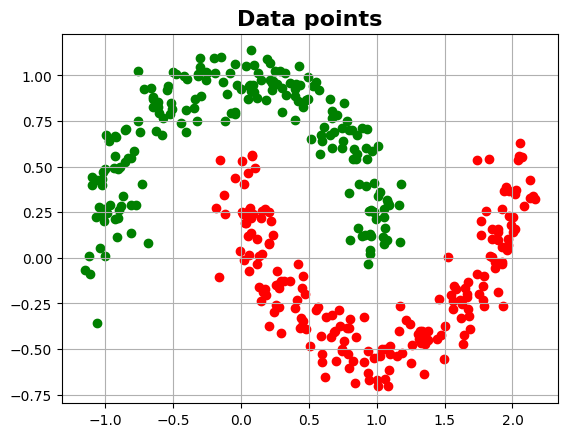

In [22]:
data,label = make_moons(n_samples=400,random_state=42,noise=0.1)
for i in range(400):
    if label[i] == 1:
        ckey = 'r'
    else:
        ckey = 'g'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)

plt.title("Data points", fontweight="bold", fontsize=16)
plt.grid()
plt.show()

data_train,data_test,y_train,y_test= train_test_split(data,label,stratify=label,test_size=0.20,random_state=123)

In [23]:
X_train_t = torch.from_numpy(data_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)

X_test_t = torch.from_numpy(data_test).to(torch.float32)
y_test_t = torch.from_numpy(y_test).to(torch.float32)

batch_size=10
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Definine the QNN

In [24]:
n_qubits = 2
n_blocks = 2 #number of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
n_layer = 2  #layers per block (multiple “layers” of StronglyEntanglingLayers per block )

loss_function = nn.BCEWithLogitsLoss()


In [25]:
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, diff_method="backprop")
def qnode(inputs,weights):
    for i in range(n_blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weights_shape = (n_blocks, n_layer, n_qubits, 3)
weight_shapes = {"weights": weights_shape}

In [26]:
class Net(nn.Module):
    def __init__(self,qnode):
        super().__init__()
        self.qnn = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.fc3 = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = self.qnn(x)
        x = self.fc3(x)
        return x


In [27]:
model = Net(qnode)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [28]:
def train(model, epochs):
    losses = []
    max_epochs = epochs
    stop_it = False
    for epoch in range(max_epochs):
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_function(outp.flatten(), y_batch)
            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()
            probabilities = torch.sigmoid(outp)
            preds = (probabilities>0.5).type(torch.long)
        print("Epoch :",epoch, "Loss:",loss.detach().flatten()[0].numpy())
    return model, losses

In [29]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

### Train the model

In [30]:
model, losses = train(model, 50)

Epoch : 0 Loss: 0.61573124
Epoch : 1 Loss: 0.5153705
Epoch : 2 Loss: 0.43052778
Epoch : 3 Loss: 0.3713492
Epoch : 4 Loss: 0.3302662
Epoch : 5 Loss: 0.300585
Epoch : 6 Loss: 0.27647766
Epoch : 7 Loss: 0.25355223
Epoch : 8 Loss: 0.2304513
Epoch : 9 Loss: 0.20893452
Epoch : 10 Loss: 0.19093734
Epoch : 11 Loss: 0.17665237
Epoch : 12 Loss: 0.16530515
Epoch : 13 Loss: 0.15605257
Epoch : 14 Loss: 0.14823666
Epoch : 15 Loss: 0.14139964
Epoch : 16 Loss: 0.13524833
Epoch : 17 Loss: 0.12961036
Epoch : 18 Loss: 0.12438909
Epoch : 19 Loss: 0.119528316
Epoch : 20 Loss: 0.11499262
Epoch : 21 Loss: 0.11075427
Epoch : 22 Loss: 0.106790386
Epoch : 23 Loss: 0.10307883
Epoch : 24 Loss: 0.09960034
Epoch : 25 Loss: 0.09633639
Epoch : 26 Loss: 0.09327023
Epoch : 27 Loss: 0.09038604
Epoch : 28 Loss: 0.08766922
Epoch : 29 Loss: 0.08510645
Epoch : 30 Loss: 0.082685605
Epoch : 31 Loss: 0.08039489
Epoch : 32 Loss: 0.078224175
Epoch : 33 Loss: 0.076163635
Epoch : 34 Loss: 0.07420448
Epoch : 35 Loss: 0.07233904
Epo

### Prediction

In [31]:
pred_train=predict(train_dataloader, model)
pred_test=predict(test_dataloader, model)

In [32]:
print("Accuracy Train:",accuracy_score(y_train,pred_train))
print("Accuracy Test:",accuracy_score(y_test,pred_test))


Accuracy Train: 0.978125
Accuracy Test: 0.9875


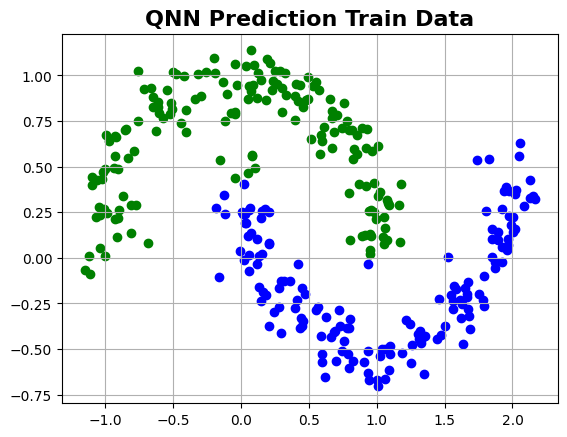

In [33]:
for i in range(len(y_train)):
    if pred_train[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data_train[i, 0], data_train[i, 1], color=ckey)
plt.grid()
plt.title("QNN Prediction Train Data", fontsize=16, fontweight="bold")
plt.show()

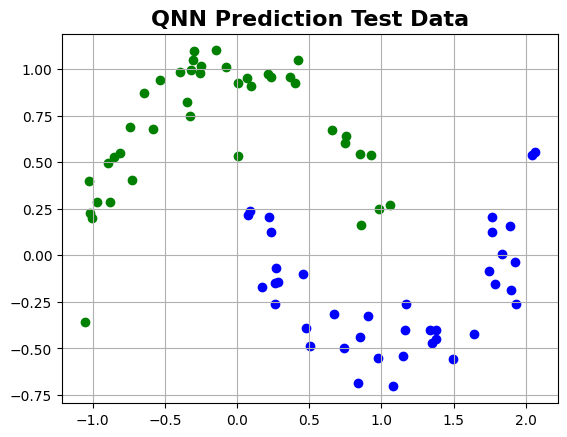

In [34]:
for i in range(len(y_test)):
    if pred_test[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data_test[i, 0], data_test[i, 1], color=ckey)
plt.grid()
plt.title("QNN Prediction Test Data", fontsize=16, fontweight="bold")
plt.show()